In [1]:
import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("HDFCBANK.csv")

In [3]:
df.shape

(5204, 15)

In [4]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
1,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
3,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
4,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN


In [5]:
stock = df["Close"]

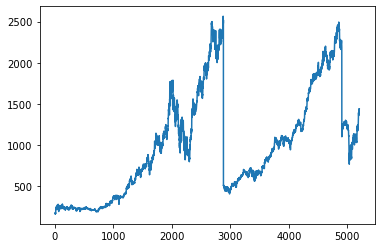

In [6]:
plt.plot(stock)

In [7]:
#Minmax Scaling
def minmax(X):
  return (X - X.min())/ (X.max() - X.min())

stock_scaled = minmax(stock)

In [8]:
stock_scaled


0       0.002747
1       0.004329
2       0.001478
3       0.002040
4       0.002060
          ...   
5199    0.512488
5200    0.530636
5201    0.515901
5202    0.525828
5203    0.531739
Name: Close, Length: 5204, dtype: float64

In [9]:
train = stock_scaled.head(3642)
test = stock_scaled.tail(1562)

In [10]:
# Prepare data
def prepare_data(data, time_step):
    X, y =[],[]
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + time_step
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:

time_step = 100
X_train, y_train = prepare_data(train.values,time_step)
X_test, y_test = prepare_data(test.values, time_step)

In [12]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train,y_train,epochs=100,batch_size=100)

Epoch 1/100
36/36 [==============================] - 16s 250ms/step - loss: 0.0397
Epoch 2/100
36/36 [==============================] - 9s 240ms/step - loss: 0.0017
Epoch 3/100
36/36 [==============================] - 9s 239ms/step - loss: 0.0022
Epoch 4/100
36/36 [==============================] - 9s 239ms/step - loss: 0.0022
Epoch 5/100
36/36 [==============================] - 9s 241ms/step - loss: 0.0020
Epoch 6/100
36/36 [==============================] - 9s 239ms/step - loss: 0.0013
Epoch 7/100
36/36 [==============================] - 9s 240ms/step - loss: 0.0017
Epoch 8/100
36/36 [==============================] - 9s 242ms/step - loss: 0.0019
Epoch 9/100
36/36 [==============================] - 9s 245ms/step - loss: 0.0012
Epoch 10/100
36/36 [==============================] - 9s 243ms/step - loss: 0.0012
Epoch 11/100
36/36 [==============================] - 9s 250ms/step - loss: 0.0011
Epoch 12/100
36/36 [==============================] - 9s 248ms/step - loss: 0.0015
Epoch 13/100

36/36 [==============================] - 9s 261ms/step - loss: 2.9002e-04
Epoch 96/100
36/36 [==============================] - 9s 264ms/step - loss: 2.0121e-04
Epoch 97/100
36/36 [==============================] - 9s 252ms/step - loss: 3.1176e-04
Epoch 98/100
36/36 [==============================] - 9s 244ms/step - loss: 1.2606e-04
Epoch 99/100
36/36 [==============================] - 9s 243ms/step - loss: 2.9515e-04
Epoch 100/100
36/36 [==============================] - 9s 246ms/step - loss: 4.4516e-04


In [14]:
y_pred = model.predict(X_test)

In [15]:

# reverse scaling
def minmax_reverse(X_norm,X):
    return (X_norm * (X.max() - X.min())) + X.min()
y_pred_actual = minmax_reverse(y_pred,stock)
y_test_actual = minmax_reverse(y_test,stock)

np.sqrt(mean_squared_error(y_test_actual,y_pred_actual))

41.63800770181121

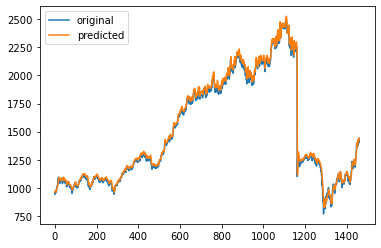

In [16]:
# plot original and predicted values
plt.figure()
plt.plot(y_test_actual,label="original")
plt.plot(y_pred_actual,label="predicted")
plt.legend()
plt.show()

In [17]:

n = 200
predicted_values = []
last_100 = X_test[-1].reshape(1,100,1)

while n>=1:
  predicted = model.predict(last_100)
  predicted_values.append(predicted[0][0])
  last_100 = np.append(last_100,predicted)[1:].reshape(1,100,1)
  n-=1

In [18]:
forecast = minmax_reverse(np.array(predicted_values),stock)

In [19]:
forecast

array([1437.4249, 1448.8633, 1461.9167, 1475.4149, 1489.131 , 1503.0302,
       1517.1736, 1531.659 , 1546.5673, 1561.9277, 1577.7106, 1593.8375,
       1610.2067, 1626.7179, 1643.2932, 1659.8889, 1676.4957, 1693.1328,
       1709.8357, 1726.6465, 1743.603 , 1760.7354, 1778.0638, 1795.6007,
       1813.3531, 1831.3254, 1849.5172, 1867.93  , 1886.5585, 1905.3926,
       1924.4158, 1943.6019, 1962.9177, 1982.3208, 2001.7644, 2021.1953,
       2040.5598, 2059.801 , 2078.8638, 2097.695 , 2116.2463, 2134.471 ,
       2152.3313, 2169.7974, 2186.8462, 2203.466 , 2219.6538, 2235.417 ,
       2250.7705, 2265.738 , 2280.3477, 2294.63  , 2308.6177, 2322.3386,
       2335.8157, 2349.0637, 2362.087 , 2374.8784, 2387.4185, 2399.6746,
       2411.6042, 2423.1577, 2434.2793, 2444.914 , 2455.012 , 2464.5325,
       2473.452 , 2481.765 , 2489.492 , 2496.6763, 2503.3872, 2509.7146,
       2515.7664, 2521.659 , 2527.5083, 2533.4204, 2539.4792, 2545.738 ,
       2552.2112, 2558.865 , 2565.6216, 2572.358 , 

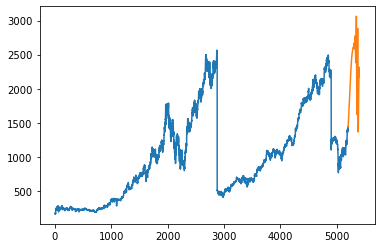

In [20]:
plt.figure()
plt.plot(stock.index,stock)
plt.plot(np.arange(5204,5404),forecast)
plt.show()